In [2]:
import gym
from gym import spaces
from gym.utils import seeding
from tqdm import tqdm

In [3]:
import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [4]:
from neuralprophet import NeuralProphet

In [5]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)

2021-01-20 16:29:17,961	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.101',
 'raylet_ip_address': '192.168.0.101',
 'redis_address': '192.168.0.101:6379',
 'object_store_address': '/tmp/ray/session_2021-01-20_16-29-17_449574_5388/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-20_16-29-17_449574_5388/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-20_16-29-17_449574_5388',
 'metrics_export_port': 56243}

In [6]:
def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv("csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


In [7]:
load_data('csvdata',['SPY','QQQ',], datetime(2010, 5, 4), datetime(2020, 12, 31), ["volatility_20", "skewness_20", "kurtosis_20"] ) ['data'][:10,:]

array([[-2.36998991e-02,  4.25369008e-05,  1.09934270e-02,
        -9.14812793e-01, -2.61064489e-01, -3.01849936e-02,
         1.03231135e-04,  1.16465557e-02, -1.10048552e+00,
         5.96949184e-01],
       [-5.94984959e-03,  4.27953952e-05,  1.09991806e-02,
        -9.10788716e-01, -2.70376218e-01, -5.12061786e-03,
         1.03745202e-04,  1.16723407e-02, -9.95452223e-01,
         4.23777969e-01],
       [-3.36369023e-02,  4.42928644e-05,  1.30807177e-02,
        -9.16682320e-01, -2.54900342e-01, -3.36202334e-02,
         0.00000000e+00,  1.37192261e-02, -9.68839072e-01,
        -4.24718444e-02],
       [-1.49229482e-02,  4.49216118e-05,  1.31754036e-02,
        -7.10326792e-01, -5.75516042e-01, -2.49435926e-02,
         0.00000000e+00,  1.45399702e-02, -7.26873145e-01,
        -6.77999658e-01],
       [ 4.29173814e-02,  4.30496362e-05,  1.66156842e-02,
         3.64864054e-01,  7.49281745e-01,  5.01088321e-02,
         1.04701078e-04,  1.85963149e-02,  4.85487538e-01,
         1.

Train neural prophet on returns, unfortunately we have to currently train one model for each stock.
We will train on data from 2010 to end of 2017, using the rest as a validation set.

In [8]:
data_QQQ = load_data('csvdata',['QQQ'], datetime(2010, 1, 1), datetime(2017, 12, 31), [])
frame_data = {'ds': data_QQQ['dates'], 'y': data_QQQ['pricedata']} # neuralprophet requires these column names
QQQ_pricedata_frame = pd.DataFrame(frame_data)

model_QQQ = NeuralProphet(
    n_lags=40, # lookback
    changepoints_range=0.85,
    num_hidden_layers=10,
    n_changepoints=50,
    normalize=True,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    loss_func='MSE',
    batch_size=64,
    epochs=300,
    learning_rate=0.01
)
metrics = model_QQQ.fit(QQQ_pricedata_frame, freq='1d', validate_each_epoch=True, valid_p=0.2)

INFO: nprophet - _handle_missing_data: 972 missing dates were added.
INFO: nprophet - _handle_missing_data: 972 NaN values in column y were auto-imputed.
ERROR: nprophet.df_utils - get_normalization_params: Normalization True not defined.
Epoch[300/300]: 100%|██████████| 300/300 [00:50<00:00,  5.91it/s, MSELoss=2.47e-5, MAE=0.00353, RegLoss=0, MAE_val=0.00505, MSELoss_val=5.21e-5]


Test the future predictions on QQQ

INFO: nprophet - _handle_missing_data: 972 missing dates were added.
INFO: nprophet - _handle_missing_data: 972 NaN values in column y were auto-imputed.


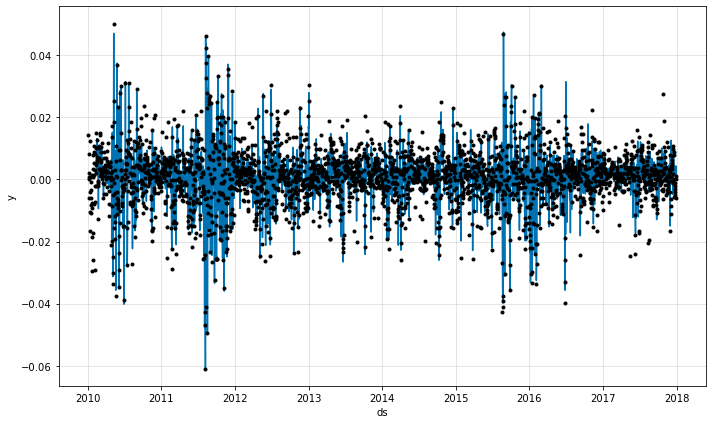

In [9]:
future = model_QQQ.make_future_dataframe(QQQ_pricedata_frame, n_historic_predictions=True)
forecast = model_QQQ.predict(future)
fig = model_QQQ.plot(forecast)

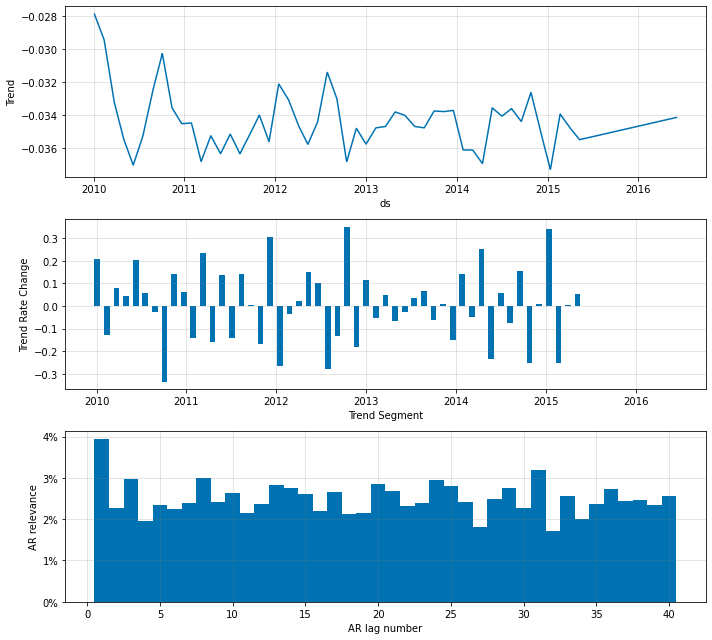

In [10]:
#model_QQQ = model_QQQ.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
fig_param = model_QQQ.plot_parameters()

INFO: nprophet - _handle_missing_data: 241 missing dates were added.
INFO: nprophet - _handle_missing_data: 241 NaN values in column y were auto-imputed.
            ds         y         t  y_scaled
0   2018-01-02  0.016544  1.247330  0.016544
1   2018-01-03  0.009213  1.247757  0.009213
2   2018-01-04  0.001666  1.248185  0.001666
3   2018-01-05  0.009526  1.248612  0.009526
4   2018-01-06  0.007585  1.249039  0.007585
..         ...       ...       ...       ...
725 2019-12-28 -0.002620  1.557027 -0.002620
726 2019-12-29 -0.004438  1.557454 -0.004438
727 2019-12-30 -0.006256  1.557881 -0.006256
728 2019-12-31  0.001791  1.558308  0.001791
729 2020-01-01       NaN  1.558736       NaN

[730 rows x 4 columns]
            ds         y       yhat1   residual1        ar1      trend
0   2018-01-02  0.016544        None        None       None       None
1   2018-01-03  0.009213        None        None       None       None
2   2018-01-04  0.001666        None        None       None       Non

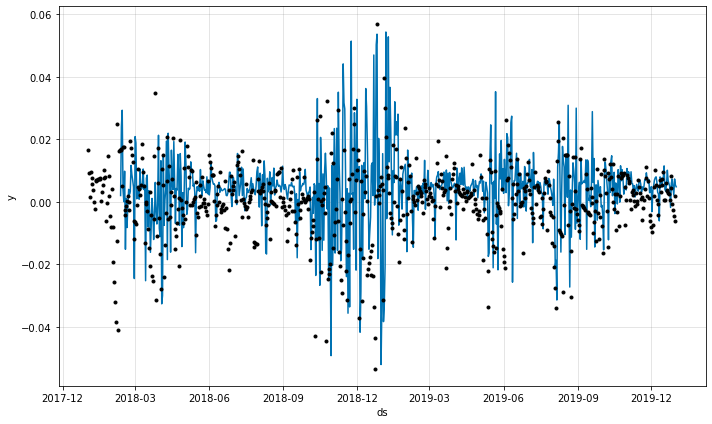

In [29]:
out_of_sample_data_QQQ = load_data('csvdata',['QQQ'], datetime(2018, 1, 1), datetime(2019, 12, 31), [])
frame_data = {'ds': out_of_sample_data_QQQ['dates'], 'y': out_of_sample_data_QQQ['pricedata']}
out_of_sample_QQQ_pricedata_frame = pd.DataFrame(frame_data)

future = model_QQQ.make_future_dataframe(out_of_sample_QQQ_pricedata_frame, n_historic_predictions=True)
print(future)
forecast = model_QQQ.predict(future)
print(forecast)
fig = model_QQQ.plot(forecast)

In [33]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        self.random_start = env_config['random_start']
        self.trading_days = env_config['trading_days'] # Number of days the algorithm runs before resetting
        self.prophet_models = env_config['prophet_models'] if 'prophet_models' in env_config else None
        self.prophet_fields = 0
        if self.prophet_models is not None:
            assert(len(self.prophet_models) == len(self.tickers), 'Each ticker needs a prophet model!')
            self.prophet_fields = 1
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers)
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields) + self.prophet_fields
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        # Trade every 10 days 
        # Normalise action space 
        if (self.index - self.start_index) % 10 == 0:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        #print(recent_series)
        rolling_volatility = np.std(recent_series)
        self.metric = today_portfolio_return / rolling_volatility 
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.trading_days is None:
            done = self.index >= self.pricedata.shape[0]-2
        else:
            done = (self.index - self.start_index) >= self.trading_days
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, False, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0           
        if self.random_start:
            num_days = len(self.dates)      
            self.start_index = np.random.randint(self.lookback, num_days - self.trading_days)
            self.index = self.start_index
        else:
            self.start_index = self.lookback
            self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        last_lookback_day = self.index - self.start_index
        price_lookback = self.featuredata[last_lookback_day:last_lookback_day + self.lookback,:]
        metrics = np.vstack((self.log_return_series[last_lookback_day:last_lookback_day + self.lookback], 
                             self.metric_series[last_lookback_day:last_lookback_day + self.lookback])).transpose()
        positions = self.position_series[last_lookback_day:last_lookback_day + self.lookback]
        scaler = StandardScaler()
        price_lookback = scaler.fit_transform(price_lookback)
        
        if self.prophet_models is not None:
            prophet_preds = []
            for idx, ticker in enumerate(self.tickers):
                model = self.prophet_models[ticker]
                df = pd.DataFrame({'ds': self.dates[last_lookback_day:last_lookback_day + self.lookback], 'y': self.featuredata[last_lookback_day:last_lookback_day + self.lookback, idx]})
                future = model.make_future_dataframe(df, n_historic_predictions=0)
                forecast = model.predict(future)
                prophet_preds.append(forecast.yhat1[-1])
            observation = np.concatenate((price_lookback, metrics, positions, np.array(prophet_preds)), axis=1)
        else:
            observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [ ]:
# Train neural prophet models for multiple stocks

stocks = ['BRK','TLT','QQQ','GLD']
models = {}

run_period = (datetime(2010, 1, 1), datetime(2017, 12, 31))

for stock in stocks:
    data = load_data('csvdata',[stock], run_period[0], run_period[1], [])
    frame_data = {'ds': data['dates'], 'y': data['pricedata']}
    pd_frame = pd.DataFrame(frame_data)

    model = NeuralProphet(
        n_lags=20, # lookback
        changepoints_range=0.85,
        num_hidden_layers=10,
        n_changepoints=50,
        normalize=True,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        loss_func='MSE',
        batch_size=128,
        epochs=300,
        learning_rate=0.01
    )
    metrics = model.fit(pd_frame, freq='1d', validate_each_epoch=True, valid_p=0.2)
    models[stock] = model


In [34]:
env_config = {'pricing_source':'csvdata', 'tickers': stocks, 
          'lookback':150, 'start':'2010-01-01', 'end':'2017-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"], 'random_start': True, 'trading_days':600,
          'prophet_models': models}

NameError: name 'models' is not defined

In [ ]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 100
config["train_batch_size"] = 500
config["buffer_size"] = 10000

config["no_done_at_end"] = True
config["horizon"] = env_config['trading_days']

config["Q_model"]["fcnet_hiddens"] = [128, 128]
config["policy_model"]["fcnet_hiddens"] = [128, 128]
config["num_cpus_per_worker"] = 2 
config["env_config"] = env_config

In [ ]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [ ]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

In [ ]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

<AxesSubplot:>

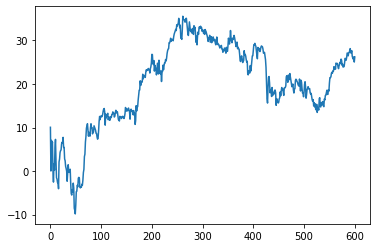

In [11]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([1,0,0,0,0])
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

PPO policy

In [12]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 5
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 1200
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['dim'] = 200
config['model']['conv_filters'] = [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = {'pricing_source':'csvdata', "tickers": ["BRK_A", "GE_","GOLD_", "AAPL_","GS_","T_",],
          'lookback':200, 'start':'1995-01-02', 'end':'2018-12-31', 'features':["return_volatility_20", "return_skewness_20", "return_kurtosis_20"],
          'random_start': True, 'trading_days': 600}

In [ ]:
config

Check to see if agents can be trained

In [ ]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

In [ ]:
for i in tqdm(range(300)):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 10:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

In [ ]:
result

In [84]:
agent.restore('sampleagent/checkpoint_1/checkpoint-1')

2020-11-24 18:16:19,141	INFO trainable.py:482 -- Restored on 192.168.0.101 from checkpoint: sampleagent/checkpoint_1/checkpoint-1
2020-11-24 18:16:19,142	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 24.549320936203003, '_episodes_total': 9}


In [85]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 1:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_2/checkpoint-2
-18.499785088445154
sampleagent/checkpoint_3/checkpoint-3
-16.556459086976048
sampleagent/checkpoint_4/checkpoint-4
-14.630928403378638


SAC 

In [ ]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [ ]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 500
config["timesteps_per_iteration"] = 10
config["buffer_size"] = 10000

config["Q_model"]["fcnet_hiddens"] = [128, 128]
config["policy_model"]["fcnet_hiddens"] = [128, 128]
config["num_cpus_per_worker"] = 2 
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": ["QQQ", "EEM", "TLT", "SHY", "GLD", "SLV"],
    "lookback": 1,
    "start": "2008-01-01",
    "end": "2017-12-31",
}

In [ ]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

In [ ]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

In [ ]:
result

Run environment 

In [ ]:
config

In [87]:
agent = PPOTrainer(config, Equitydaily)

6042
2010
2020-11-24 18:19:14,974	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [92]:
env = Equitydaily(config['env_config'])

6042
1190


In [93]:
agent.restore('checkpoint_1087/checkpoint-1087')

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_1087/checkpoint-1087.tune_metadata'

In [ ]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
pd.Series(reward_list).plot()

In [ ]:
pd.DataFrame(actions)

Run environment for RNN environment

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ'], 'lookback':50, 'start':'2018-01-02', 'end':'2020-12-31'})

state = env.reset()
done = False
cum_reward = 0 
actions = list()

rnn_state = agent.get_policy().get_initial_state()

while not done:
    action, rnn_state, _ = agent.compute_action(state,rnn_state)
    #action = np.array([1,-1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(actions)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
max_drawdown(pd.Series(env.log_return_series))

In [ ]:
annual_return(pd.Series(env.log_return_series))

In [ ]:
class Equitydaily_v1(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        tcost = turnover * np.log(fees)
        return tcost 